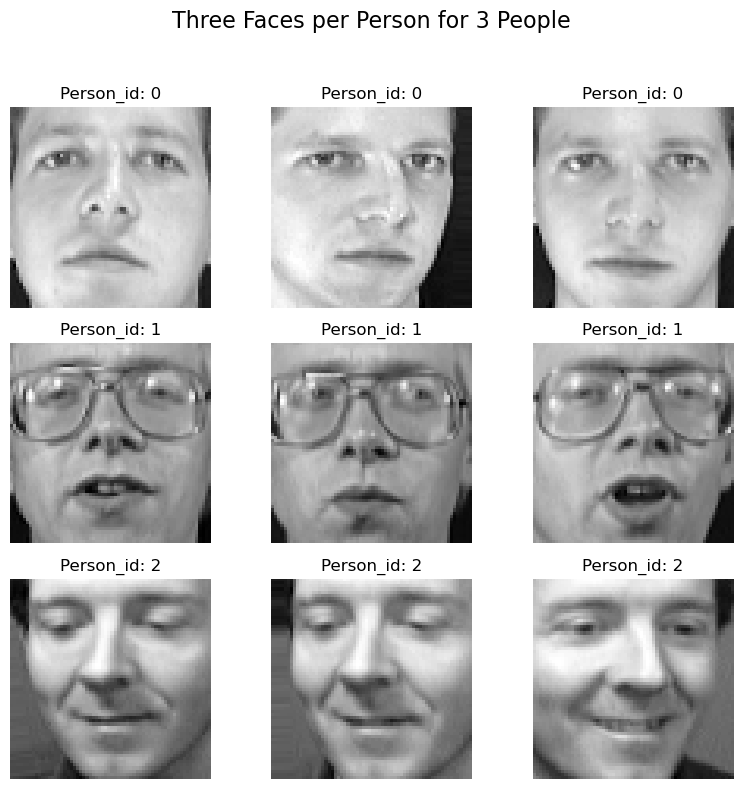

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded = torch.load("olivetti_faces_data.pth", map_location=device)
X_train = loaded['X_train']
X_test  = loaded['X_test']
y_train = loaded['y_train']
y_test  = loaded['y_test']


faces = X_train.reshape([-1,64,64])   # shape (400, 64, 64)
targets = y_train # labels from 0 to 39 (each person has 10 images)
# Select three people (e.g., persons 0, 1, and 2)
selected_people = [0, 1, 2]

# Create a subplot grid: one row per person, 3 columns (three images per person)
fig, axes = plt.subplots(nrows=len(selected_people), ncols=3, figsize=(8, 8))
fig.suptitle("Three Faces per Person for 3 People", fontsize=16)

for row, person in enumerate(selected_people):
    # Use torch.where to get indices of images for the current person
    person_indices = torch.where(targets == person)[0]
    # Select the first three indices
    selected_indices = person_indices[:3]
    for col, idx in enumerate(selected_indices):
        # Convert the face image (a torch tensor) to a NumPy array for plotting
        img = faces[idx].cpu().numpy()
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Person_id: {person}", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



Part 3(a) Computing Eigenvectors and Plotting Explained Variance

<Figure size 800x800 with 0 Axes>

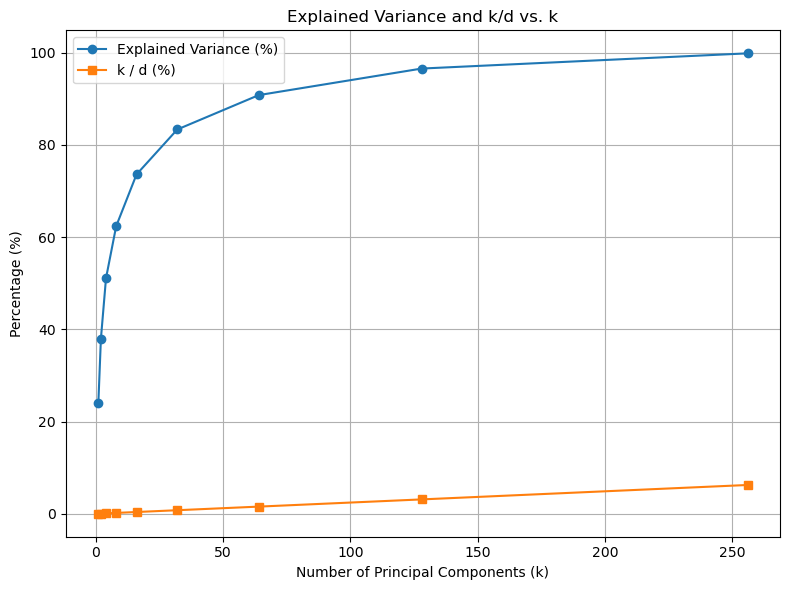

In [2]:
k_list = [1,2,4,8,16, 32,64,128,256]


# ------------------------------
X_train_np = X_train.cpu().numpy()  # shape (280, 4096)
n_samples, d = X_train_np.shape

# Center the data (subtract the mean)

X_mean = np.mean(X_train_np, axis=0)
X_centered = X_train_np - X_mean

# Compute PCA (SVD)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
explained_variance = S**2 / (n_samples - 1)
total_variance = np.sum(explained_variance)
explained_variance_ratio = explained_variance / total_variance  # shape: (4096,)


plt.figure(figsize=(8,8))
# ------------------------------
# Plot Explained Variance vs. k and k/total_dimension curve
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))

# Plot: cumulative explained variance
plt.plot(k_list, [cumulative_variance[k-1]*100 for k in k_list], marker='o', label='Explained Variance (%)')

# Plot: fraction of dimension used (k/d)
plt.plot(k_list, [k/d*100 for k in k_list], marker='s', label='k / d (%)')
# ------------------------------
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Percentage (%)")
plt.title("Explained Variance and k/d vs. k")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Part 3(b) Visualizing Top-6 Eigenvectors

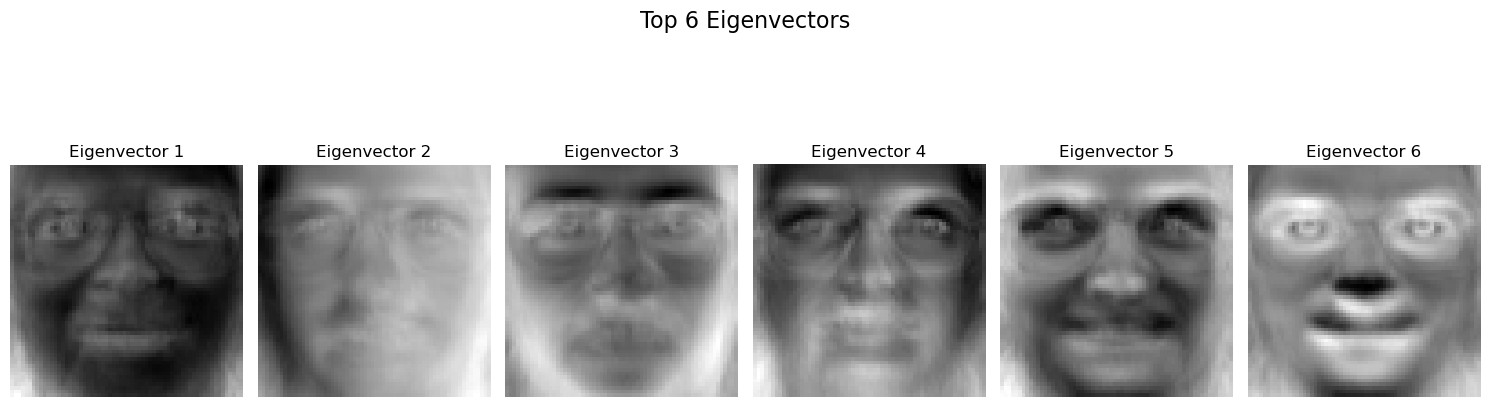

In [3]:
# Create a 1x6 grid for plotting
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
fig.suptitle("Top 6 Eigenvectors", fontsize=16)

for i in range(6):
    # ------------------------------
    eigenface = Vt[i].reshape(64, 64)  # reshape the i-th eigenvector
    axes[i].imshow(eigenface, cmap='gray')
    # ------------------------------
    axes[i].axis('off')
    axes[i].set_title(f"Eigenvector {i+1}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Part 3(c) Visualizing Reconstruction with Top-k Principal Components

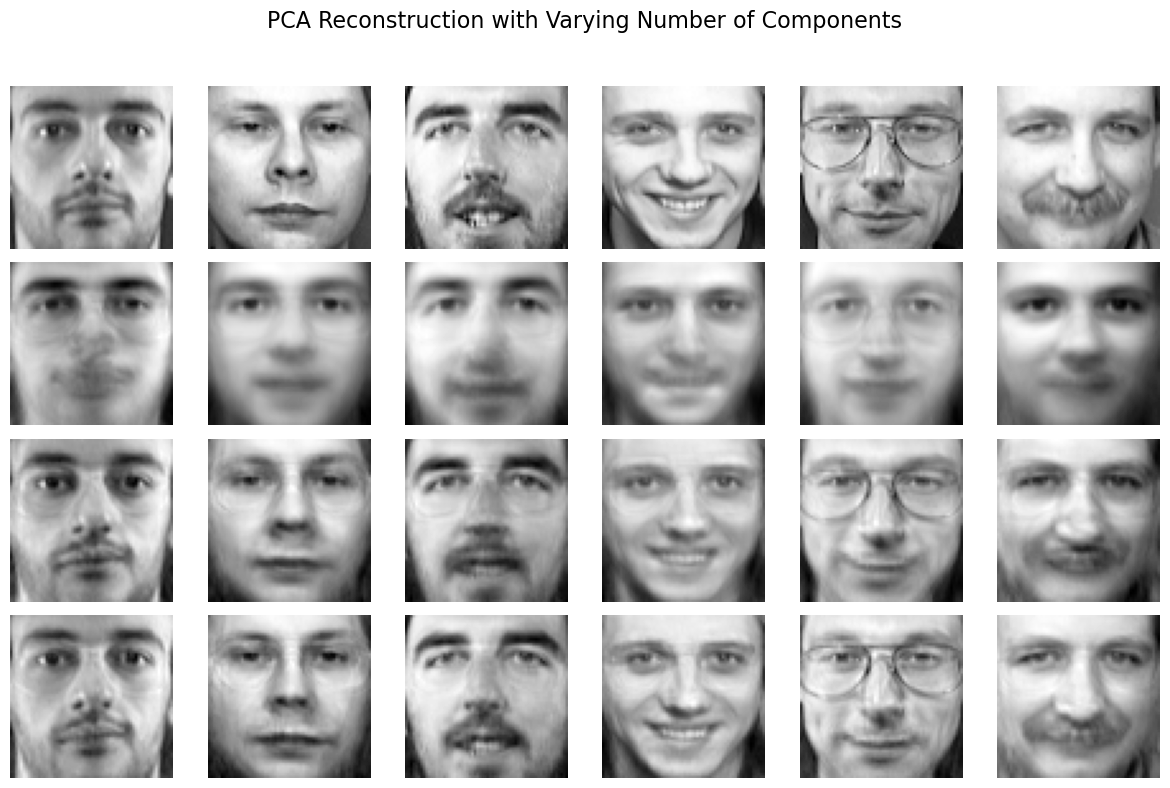

In [4]:
# Parameters
k_reconstruct = [10, 50, 100]
num_faces = 6  # first 6 training images

# Prepare 4x6 subplot grid
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
fig.suptitle("PCA Reconstruction with Varying Number of Components", fontsize=16)

# Original 6 faces (top row)
for i in range(num_faces):
    original_face = X_train_np[i].reshape(64, 64)
    axes[0, i].imshow(original_face, cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel("Original", fontsize=12)

# Reconstructions using top-k PCs
for row, k in enumerate(k_reconstruct):
    # Project into k-dimensional space and back
    V_k = Vt[:k]  # shape: (k, 4096)
    X_proj = (X_centered[:num_faces] @ V_k.T)  # shape: (6, k)
    X_reconstructed = X_proj @ V_k  # shape: (6, 4096)
    X_reconstructed += X_mean  # add the mean back

    for i in range(num_faces):
        img = X_reconstructed[i].reshape(64, 64)
        axes[row+1, i].imshow(img, cmap='gray')
        axes[row+1, i].axis('off')
        if i == 0:
            axes[row+1, i].set_ylabel(f"k={k}", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Part (d) Implement Logistic Regression and Train on Full Set of Features

In [12]:
# ------------------------------
# Define logistic regression model and solve (using pytorch+SGD or scikitlearn)
# remember to print your test accuracy on full dimensions.
# ------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Step 1: Convert tensors to NumPy arrays
X_train_np = X_train.cpu().numpy()     # shape: (280, 4096)
X_test_np = X_test.cpu().numpy()       # shape: (120, 4096)
y_train_np = y_train.cpu().numpy()     # shape: (280,)
y_test_np = y_test.cpu().numpy()       # shape: (120,)

# Step 2: Train logistic regression on full features
clf_raw = LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial')
clf_raw.fit(X_train_np, y_train_np)

# Step 3: Predict and evaluate on test set
y_pred_raw = clf_raw.predict(X_test_np)
accuracy_raw = accuracy_score(y_test_np, y_pred_raw) * 100


print(f"Test accuracy using all 4096 raw pixels: {accuracy_raw:.2f}%")

/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test accuracy using all 4096 raw pixels: 98.33%


Part 3(e)

In [14]:

eigvecs = torch.from_numpy(Vt.T).float().to(device)  # shape (4096, 4096)
eigvals = torch.from_numpy((S**2 / (280 - 1))).float().to(device)  # shape (4096,)
total_variance = torch.sum(eigvals)

X_train_centered = torch.from_numpy(X_train_np - X_mean).float().to(device)
X_test_centered  = torch.from_numpy(X_test_np - X_mean).float().to(device)

num_classed = 40


/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


k =   1: Explained Variance = 24.07%, k/4096 =  0.02%, Test Accuracy = 11.67%
k =   2: Explained Variance = 37.97%, k/4096 =  0.05%, Test Accuracy = 19.17%


/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


k =   4: Explained Variance = 51.06%, k/4096 =  0.10%, Test Accuracy = 42.50%
k =   8: Explained Variance = 62.36%, k/4096 =  0.20%, Test Accuracy = 75.83%


/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


k =  16: Explained Variance = 73.59%, k/4096 =  0.39%, Test Accuracy = 90.83%


/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


k =  32: Explained Variance = 83.32%, k/4096 =  0.78%, Test Accuracy = 97.50%


/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


k =  64: Explained Variance = 90.78%, k/4096 =  1.56%, Test Accuracy = 98.33%


/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


k = 128: Explained Variance = 96.53%, k/4096 =  3.12%, Test Accuracy = 98.33%


/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


k = 256: Explained Variance = 99.83%, k/4096 =  6.25%, Test Accuracy = 98.33%


/opt/anaconda3/envs/Chatgpt/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


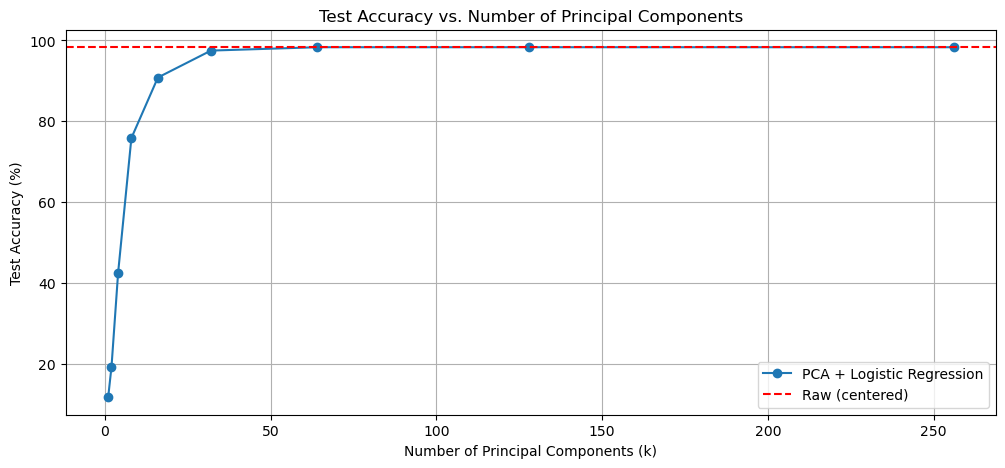

In [15]:
# ------------------------------
# PCA + Logistic Regression for different k values
# ------------------------------
k_list = [1,2,4,8,16, 32,64,128,256] # you can change this list if needed
pca_accuracies = []
explained_variances = []
k_ratios = []  # k / total_dimension (total_dimension = 4096)

for k in k_list:
    # Select top-k eigenvectors (principal components)
    pcs = eigvecs[:, :k]  # shape (4096, k)
    
    # Project centered data onto these components
    X_train_pca = X_train_centered @ pcs  # shape (n_train, k)
    X_test_pca  = X_test_centered @ pcs   # shape (n_test, k)
    
    # Compute explained variance ratio for top-k components (in percent)
    explained = torch.sum(eigvals[:k]) / total_variance
    explained_variances.append(explained.item() * 100)
    
    # Compute ratio of k to total dimension (as percent)
    k_ratios.append((k / X_train_centered.shape[1]) * 100)
    
    # Train logistic regression on PCA-reduced data
    X_train_pca_np = X_train_pca.cpu().numpy()
    X_test_pca_np = X_test_pca.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    clf = LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial')
    clf.fit(X_train_pca_np, y_train_np)
    y_pred = clf.predict(X_test_pca_np)
    accuracy_pca = accuracy_score(y_test_np, y_pred) * 100
    pca_accuracies.append(accuracy_pca)
    
    print(f"k = {k:3d}: Explained Variance = {explained.item()*100:5.2f}%, k/4096 = {k/4096*100:5.2f}%, Test Accuracy = {accuracy_pca:5.2f}%")

# ------------------------------
# Plot Test Accuracy and Explained Variance vs. k
# ------------------------------
plt.figure(figsize=(12, 5))

# Plot Test Accuracy vs. k
plt.plot(k_list, pca_accuracies, marker='o', label='PCA + Logistic Regression')
plt.axhline(y=accuracy_raw, color='red', linestyle='--', label='Raw (centered)')
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy vs. Number of Principal Components")
plt.legend()
plt.grid(True)

plt.show()

